# Wine quality prediction with a Dense Network (DNN)

The **[Wine Quality datasets](https://archive.ics.uci.edu/ml/datasets/wine+Quality)** are made up of analyses of a large number of wines, with an associated quality (between 0 and 10)  
This dataset is provide by :  
Paulo Cortez, University of Minho, Guimarães, Portugal, http://www3.dsi.uminho.pt/pcortez  
A. Cerdeira, F. Almeida, T. Matos and J. Reis, Viticulture Commission of the Vinho Verde Region(CVRVV), Porto, Portugal, @2009  
This dataset can be retreive at [University of California Irvine (UCI)](https://archive-beta.ics.uci.edu/ml/datasets/wine+quality)

The dataset contains information about :
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality (score between 0 and 10)




## Step 1 - Import and init


In [2]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

import fidle

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('WINE1')

<br>**FIDLE - Environment initialization**

Version              : 2.0b56
Run id               : WINE1
Run dir              : ./run/WINE1
Datasets dir         : C:\Users\chehidas\Documents\Formations\2023\fidle22-23\datasets-fidle
Start time           : 27/07/23 10:29:58
Hostname             : extravache (Windows)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Save figs            : ./run/WINE1/figs (False)
tensorflow           : 2.9.0
numpy                : 1.24.3
sklearn              : 1.1.3
matplotlib           : 3.6.2
pandas               : 1.5.2


Verbosity during training : 
- 0 = silent
- 1 = progress bar
- 2 = one line per epoch

In [3]:
fit_verbosity = 1
dataset_name  = 'winequality-red.csv'

Override parameters (batch mode) - Just forget this cell

In [4]:
fidle.override('fit_verbosity', 'dataset_name')

## Step 2 - Retrieve data

In [5]:
data = pd.read_csv(f'{datasets_dir}/WineQuality/origine/{dataset_name}', header=0,sep=';')
display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5.00
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5.00
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6.00
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00


Missing Data :  0   Shape is :  (1599, 12)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be the data of the analysis and y the quality

In [6]:
# ---- Split => train, test
#
data       = data.sample(frac=1., axis=0)     # Shuffle
data_train = data.sample(frac=0.8, axis=0)    # get 80 %
data_test  = data.drop(data_train.index)      # test = all - train

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('quality',  axis=1)
y_train = data_train['quality']
x_test  = data_test.drop('quality',   axis=1)
y_test  = data_test['quality']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (1599, 12)
x_train :  (1279, 11) y_train :  (1279,)
x_test  :  (320, 11) y_test  :  (320,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [7]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

# Convert ou DataFrame to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.33,0.53,0.27,2.57,0.09,16.06,46.85,1.00,3.31,0.66,10.45
std,1.75,0.18,0.20,1.45,0.05,10.56,33.14,0.00,0.16,0.17,1.08
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40
25%,7.10,0.39,0.10,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20
75%,9.25,0.64,0.42,2.60,0.09,22.00,63.00,1.00,3.40,0.73,11.10
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.13,-2.27,-1.40,-1.15,-1.59,-1.43,-1.23,-3.49,-3.67,-1.96,-1.91
25%,-0.70,-0.76,-0.89,-0.46,-0.36,-0.86,-0.75,-0.60,-0.64,-0.65,-0.88
50%,-0.24,-0.04,-0.07,-0.25,-0.17,-0.19,-0.27,-0.01,0.01,-0.24,-0.23
75%,0.53,0.60,0.75,0.02,0.06,0.56,0.49,0.57,0.59,0.42,0.60
max,4.33,5.87,3.71,8.93,11.10,5.30,7.31,3.64,4.52,7.96,4.14


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [8]:
def get_model_v1(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(1, name='Output'))

  model.compile(optimizer = 'rmsprop',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## 5 - Train the model
### 5.1 - Get it

In [9]:
model=get_model_v1( (11,) )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [10]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [11]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100
128/128 [==============================] - 1s 4ms/step - loss: 7.1324 - mae: 2.0712 - mse: 7.1324 - val_loss: 1.7411 - val_mae: 1.0247 - val_mse: 1.7411
Epoch 2/100
128/128 [==============================] - 0s 2ms/step - loss: 1.5470 - mae: 0.9668 - mse: 1.5470 - val_loss: 1.1070 - val_mae: 0.8274 - val_mse: 1.1070
Epoch 3/100
128/128 [==============================] - 0s 2ms/step - loss: 1.0662 - mae: 0.8027 - mse: 1.0662 - val_loss: 0.8836 - val_mae: 0.7296 - val_mse: 0.8836
Epoch 4/100
128/128 [==============================] - 0s 2ms/step - loss: 0.7998 - mae: 0.6953 - mse: 0.7998 - val_loss: 0.6738 - val_mae: 0.6257 - val_mse: 0.6738
Epoch 5/100
128/128 [==============================] - 0s 2ms/step - loss: 0.6617 - mae: 0.6305 - mse: 0.6617 - val_loss: 0.5564 - val_mae: 0.5784 - val_mse: 0.5564
Epoch 6/100
128/128 [==============================] - 0s 2ms/step - loss: 0.5569 - mae: 0.5772 - mse: 0.5569 - val_loss: 0.4892 - val_mae: 0.5370 - val_mse: 0.4892
Epoch 7/10

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.4539
x_test / mae       : 0.5079
x_test / mse       : 0.4539


### 6.2 - Training history
What was the best result during our training ?

In [13]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 0.4504


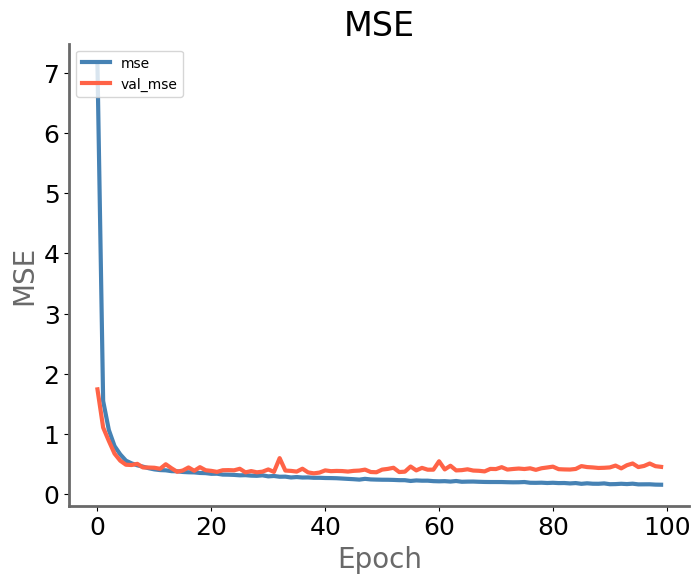

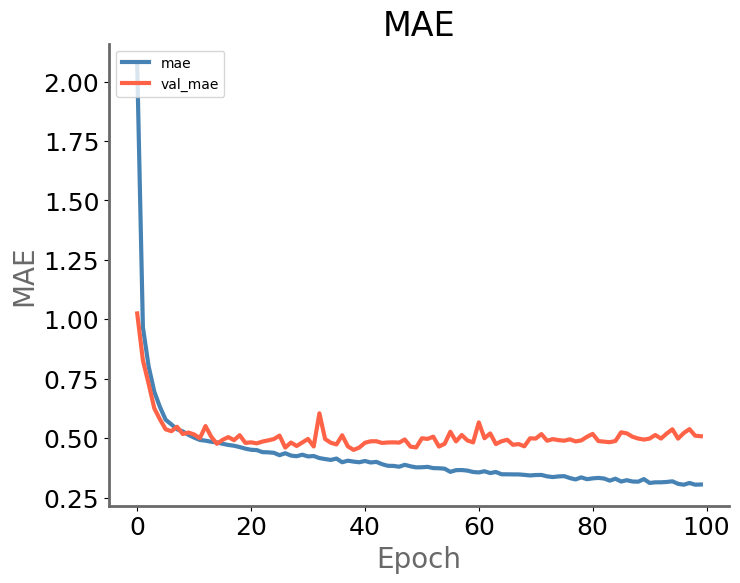

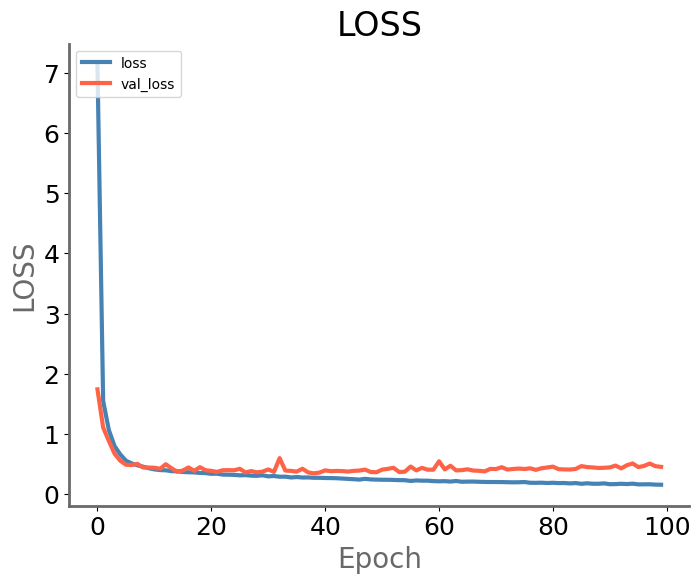

In [14]:
fidle.scrawler.history( history, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [15]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [16]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.3463
x_test / mae       : 0.4504
x_test / mse       : 0.3463


### 7.3 - Make a prediction

In [17]:
# ---- Pick n entries from our test set
n = 200
ii = np.random.randint(1,len(x_test),n)
x_sample = x_test[ii]
y_sample = y_test[ii]

In [18]:
# ---- Make a predictions
y_pred = loaded_model.predict( x_sample, verbose=2 )

7/7 - 0s - 132ms/epoch - 19ms/step


In [19]:
# ---- Show it
print('Wine    Prediction   Real   Delta')
for i in range(n):
    pred   = y_pred[i][0]
    real   = y_sample[i]
    delta  = real-pred
    print(f'{i:03d}        {pred:.2f}       {real}      {delta:+.2f} ')

Wine    Prediction   Real   Delta
000        5.08       5      -0.08 
001        6.09       6      -0.09 
002        4.58       5      +0.42 
003        5.49       5      -0.49 
004        4.41       5      +0.59 
005        4.80       6      +1.20 
006        5.60       6      +0.40 
007        5.38       6      +0.62 
008        4.73       5      +0.27 
009        6.33       6      -0.33 
010        6.10       5      -1.10 
011        5.92       7      +1.08 
012        5.90       6      +0.10 
013        6.48       7      +0.52 
014        5.03       5      -0.03 
015        4.96       5      +0.04 
016        5.32       5      -0.32 
017        4.71       5      +0.29 
018        5.38       6      +0.62 
019        6.65       6      -0.65 
020        6.00       6      -0.00 
021        5.84       6      +0.16 
022        4.90       5      +0.10 
023        6.48       6      -0.48 
024        5.65       6      +0.35 
025        4.80       6      +1.20 
026        5.44       6      +

In [20]:
fidle.end()

**End time :** 27/07/23 10:32:35  
**Duration :** 00:02:37 863ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>